# Considerando o drift ou lag na pevisão.


Nos notebook anteriores consideramos previsões utilizando dados da mesma data. Em situações reais isto é difícil. Queremos realizar privisões sem prévio conhecimento quantitativo das variáveis que a variável dependente possui correlação. 

Neste notebook estaremos utilizando as variáveis preditoras com um drift.

In [166]:
% matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 15, 6

In [167]:
db = pd.read_csv("opec/data_05_11_16.csv", index_col=0, parse_dates=True)

db_q = db.resample("Q").mean()

In [168]:
%ls eia

Markets_interest.csv     PET_CRD_CRPDN_ADC_MBBL_M.xls
nonOECD_consumption.csv  saudi_production.csv
nonOPEC_production.csv   Supply_summary.csv
OECD_consumption.csv     table3c_M_199701-201712.csv
opec_spare_capacity.csv  table4a_M_201101-201712.csv


In [169]:
features = pd.read_csv("oil_features.csv", index_col=0, parse_dates=True)

features_drift = features.shift(1)

print(features.head())
print(features_drift.head())

            y-o-y % OECD Consumption Change  non-OECD Consumption Growth  \
2001-03-31                             1.57                         2.33   
2001-06-30                             0.32                         4.67   
2001-09-30                            -0.57                         0.90   
2001-12-31                            -0.80                         2.91   
2002-03-31                            -1.51                         1.39   

            Saudi Production Change  Spare Capacity  
2001-03-31                     0.58            1.62  
2001-06-30                    -0.18            2.71  
2001-09-30                    -0.68            2.56  
2001-12-31                    -1.19            3.43  
2002-03-31                    -1.17            4.41  
            y-o-y % OECD Consumption Change  non-OECD Consumption Growth  \
2001-03-31                              NaN                          NaN   
2001-06-30                             1.57                        

In [170]:
#pd.concat([db_q, features], join="inner", axis=1).corr().to_latex()

In [171]:

X = np.array(features_drift["2003-01":"2016-06"])
y = np.array(db_q["2003-01":"2016-06"])

print(X.shape)
print(y.shape)
print(np.any(np.isnan(X)))

(54, 4)
(54, 1)
False


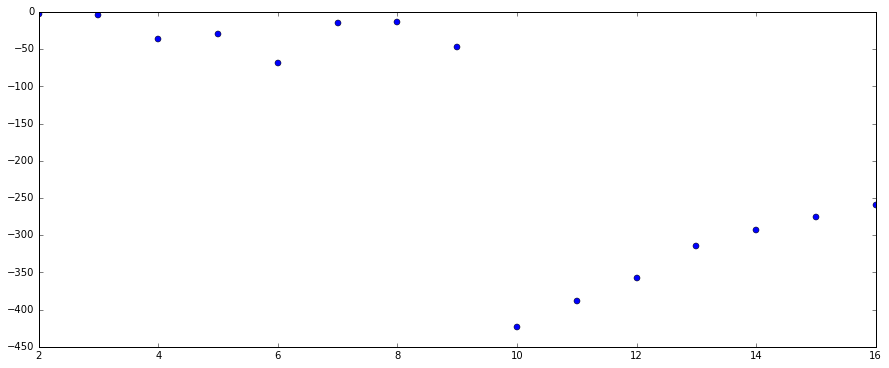

In [172]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

scores = list()
for split  in list(range(2,17)):
    tscv = TimeSeriesSplit(n_splits=split)
    lr = LinearRegression()
    score = cross_val_score(lr, X, y, cv=tscv, scoring="r2", n_jobs=4)
    scores.append(score.mean())

plt.plot(list(range(2,17)), scores, "o")    

In [173]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression


tscv = TimeSeriesSplit(n_splits=10)
train_score = list()
test_score = list()
for train_index, test_index in tscv.split(X):
        linear_regression = LinearRegression().fit(X[train_index,:], y[train_index])

In [185]:
y_pred = linear_regression.predict(X)
features_drift.columns
linear_regression.coef_
linear_regression.intercept_
linear_regression.score(X,y)

0.16149337617909454

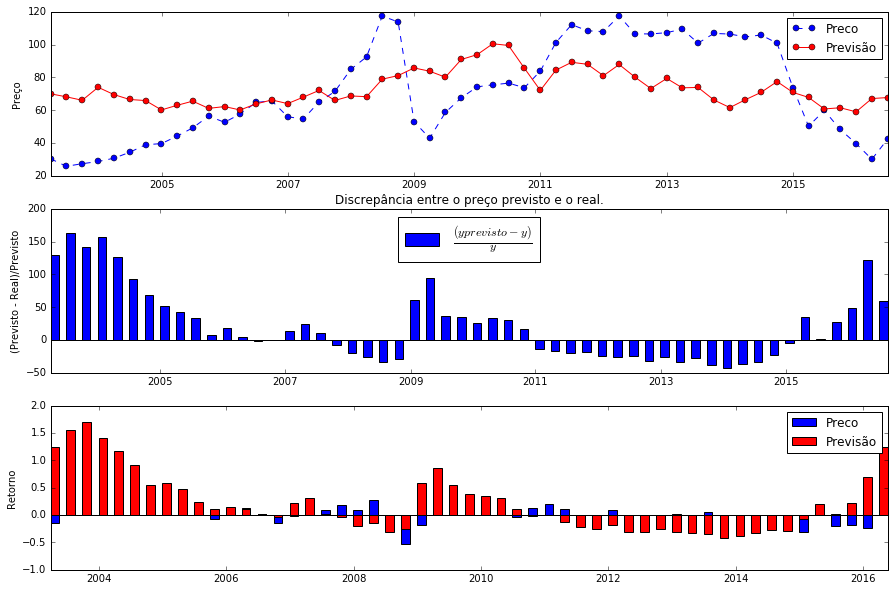

In [175]:
import matplotlib.dates as mdates
xfmt = mdates.DateFormatter('%Y')

eixo_x = features_drift["2003-01":"2016-06"].index


fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3,1,1)

ax1.plot(eixo_x, y, color="b", marker="o", linestyle="--", label="Preco")
ax1.plot(eixo_x, y_pred, color = "r", marker="o", linestyle="-", label="Previsão")
ax1.set_ylabel("Preço")
ax1.legend(loc=1)

#Cuidado do formato 
ax1.xaxis.set_major_formatter(xfmt)

ax2 = fig.add_subplot(3,1,2)
perc = ((y_pred-y)/y)*100
ax2.bar(left=eixo_x, height=perc, width = 50, align= "edge", label=r"$\frac{(yprevisto-y)}{y}$")
ax2.set_ylabel("(Previsto - Real)/Previsto")
ax2.set_title("Discrepância entre o preço previsto e o real.")
ax2.legend(loc=0, fontsize="xx-large")
ax2.axhline(0, c="k")

ax2.xaxis.set_major_formatter(xfmt)


ax3 = fig.add_subplot(3,1,3)

r_real=list()
r_pred = list()
for i in range(len(y[:])-1): 
    r_real.append((y[i+1][0]-y[i][0])/y[i])
    r_pred.append((y_pred[i+1][0]-y[i][0])/y[i])
    

ax3.bar(left=eixo_x[:-1], width = 50, height=r_real, color="b", label="Preco")
ax3.bar(left=eixo_x[:-1], width = 50, height= r_pred,  color="r", label="Previsão")
ax3.axhline(0, c="k")
ax3.set_ylabel("Retorno")
ax3.legend()

plt.savefig("prevLinear.pdf", format="pdf")

In [176]:
r_pred = np.array(r_pred)
